In [1]:
import sqlalchemy
import pandas as pd
import numpy as np

import mplfinance as mpf
import utils.ta_lib_indicators as ti

import ipywidgets as widgets
import talib


In [2]:
db_connection_string = 'sqlite:///./Resources/products.db'
engine  = sqlalchemy.create_engine(db_connection_string)

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['AAPL_1_Day_Candles', 'AAPL_1_Min_Candles', 'AAPL_Info', 'Indicators', 'MARA_1_Day_Candles', 'MARA_1_Min_Candles', 'MARA_Info', 'RIOT_1_Day_Candles', 'RIOT_1_Min_Candles', 'RIOT_Info', 'TSLA_1_Day_Candles', 'TSLA_1_Min_Candles', 'TSLA_Info', 'WHD_1_Day_Candles', 'WHD_1_Min_Candles', 'WHD_Info']


In [3]:
# Update table names by looking at the list created above
# MSFT was used to create the example, replace it with the symbol you used
stock_ticker = 'AAPL'
daily_df = pd.read_sql_table(
    stock_ticker + '_1_Day_Candles', 
    con=engine, 
    index_col='Datetime',
    )
minutely_df = pd.read_sql_table(
    stock_ticker + '_1_Min_Candles', 
    con=engine, 
    index_col='Datetime'
    )

In [4]:
# print(daily_df.tail())

In [5]:
# print(minutely_df.tail())

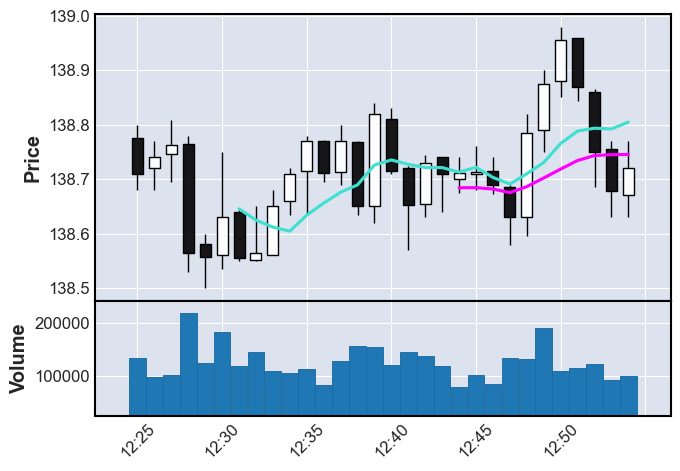

In [6]:
minutely_slice = minutely_df.iloc[-30:]
minutely_candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    minutely_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


In [7]:
pattern_list = []
pattern_df = pd.DataFrame(list(ti.pattern_recognition.items()), columns=['Index', 'Pattern'])
pattern_df = pattern_df.set_index('Index')
# print(pattern_df)
for pattern, p_name in ti.pattern_recognition.items():
    pattern_list.append(pattern)

In [8]:
df = minutely_df.copy()




In [9]:
sel = widgets.SelectMultiple(
        options=pattern_df['Pattern'],
        value=['Doji'],
        rows=min(25, len(pattern_list)),
        description='Candle Pattern:'
    )


In [10]:
output = widgets.Output()

In [11]:
button_submit = widgets.Button(
    description='Submit',
    disabled=False,
    )

In [12]:
display(sel, button_submit, output)
with output:
    print(list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index))

SelectMultiple(description='Candle Pattern:', index=(15,), options=('Two Crows', 'Three Black Crows', 'Three I…

Button(description='Submit', style=ButtonStyle())

Output()

In [25]:

def show_df(b):
    df = minutely_df.copy()
    output.clear_output()
    sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
    for pattern in sel_pattern_list:
        pattern_function = getattr(talib, pattern)
        try:
            result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
            df[pattern] = result
        except Exception as e:
            print(f"{type(e)} Exception! {e}")
    # print(df.head())
    # return df
    with output:
        print(f"{sel_pattern_list}")
        print(df.head())
    # return sel_pattern_list


button_submit.on_click(show_df)



In [26]:
# df = minutely_df.copy()
sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
for pattern in sel_pattern_list:
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern] = result
    except Exception as e:
        print(f"{type(e)} Exception! {e}")
print(df.head())


                       Open    High     Low   Close  Volume  CDLDOJI  \
Datetime                                                               
2021-09-07 03:00:00  154.60  154.66  154.27  154.62    3087        0   
2021-09-07 03:02:00  154.65  154.71  154.65  154.70    1378        0   
2021-09-07 03:03:00  154.70  154.70  154.70  154.70    1185        0   
2021-09-07 03:04:00  154.58  154.62  154.55  154.55    4789        0   
2021-09-07 03:06:00  154.54  154.54  154.54  154.54     911        0   

                     Trailing Stop  Trade Signal  Pct Change  Stop Loss  \
Datetime                                                                  
2021-09-07 03:00:00            NaN           0.0         NaN        0.0   
2021-09-07 03:02:00            NaN           0.0    0.000517        0.0   
2021-09-07 03:03:00            NaN           0.0    0.000000        0.0   
2021-09-07 03:04:00            NaN           0.0   -0.000970        0.0   
2021-09-07 03:06:00            NaN           

In [27]:
len(sel_pattern_list)
df['Sum Patterns'] = df.iloc[:, -(len(sel_pattern_list)):].sum(axis=1)
# df.drop(columns=sel_pattern_list, inplace=True)


In [28]:
atr_function = getattr(talib, 'ATR')

atr_result = atr_function(df['High'], df['Low'], df['Close'], timeperiod=14)

atr_factor = 2.5

df['Trailing Stop'] = df['Close'] - (atr_result * atr_factor)



In [29]:
df['Trade Signal'] = 0.0

threshold_value = 0.0

def check_sum_value(sum_value):
    if sum_value > threshold_value:
        return 1
    elif sum_value < -threshold_value:
        return -1
    else:
        return 0.0

df['Trade Signal'] = df['Sum Patterns'].apply(lambda x: check_sum_value(x))
df.drop(columns='Sum Patterns', inplace=True)
       

In [30]:
df['Pct Change'] = df['Close'].pct_change()


In [31]:
df['Stop Loss'] = np.where(df['Trade Signal']==1,df['Trailing Stop'],0.0)

In [32]:
print(df.iloc[:, -4:].tail(20))
print(df['Trade Signal'].value_counts())

                     Trade Signal  Pct Change  Stop Loss  CDLGAPSIDESIDEWHITE
Datetime                                                                     
2021-10-04 12:35:00           0.0    0.000433        0.0                    0
2021-10-04 12:36:00           0.0   -0.000423        0.0                    0
2021-10-04 12:37:00           0.0    0.000422        0.0                    0
2021-10-04 12:38:00           0.0   -0.000864        0.0                    0
2021-10-04 12:39:00           0.0    0.001226        0.0                    0
2021-10-04 12:40:00           0.0   -0.000756        0.0                    0
2021-10-04 12:41:00           0.0   -0.000444        0.0                    0
2021-10-04 12:42:00           0.0    0.000552        0.0                    0
2021-10-04 12:43:00           0.0   -0.000144        0.0                    0
2021-10-04 12:44:00           0.0    0.000009        0.0                    0
2021-10-04 12:45:00           0.0    0.000009        0.0        

In [33]:
# df['Recalculated Stop Loss'] = pd.NA

# for index, row in df.iterrows():
    
#     if row['Initialize Stop Loss'] > 0.0:
#         df.loc[index, 'Recalculated Stop Loss'] = row['Initialize Stop Loss']

#     elif row['Initialize Stop Loss'] > 0.0 or row['Pct Change'] > 0.0:
#         if row['Trailing Stop'] > row['Recalculated Stop Loss'].shift(1):
#             df.loc[index,'Recalculated Stop Loss'] = row['Trailing Stop']
#         else:
#             df.loc[index,'Recalculated Stop Loss'] = row['Recalculated Stop Loss'].shift(1)
    
#     else:
#         df.loc[index,'Recalculated Stop Loss'] = row['Recalculated Stop Loss'].shift(1)

In [34]:
last_stop = 0.0
# df['Recalculated Stop Loss'] = pd.NA
for index, row in df.iterrows():
    if row['Pct Change'] > 0.0 and row['Trailing Stop'] > last_stop:
        df.loc[index,'Stop Loss'] = row['Trailing Stop']
    else:
        df.loc[index,'Stop Loss'] = last_stop

    last_stop = row['Stop Loss']


In [35]:
print(df.iloc[:, -5:].head(20))

                     Trailing Stop  Trade Signal  Pct Change   Stop Loss  \
Datetime                                                                   
2021-09-07 03:00:00            NaN           0.0         NaN    0.000000   
2021-09-07 03:02:00            NaN           0.0    0.000517    0.000000   
2021-09-07 03:03:00            NaN           0.0    0.000000    0.000000   
2021-09-07 03:04:00            NaN           0.0   -0.000970    0.000000   
2021-09-07 03:06:00            NaN           0.0   -0.000065    0.000000   
2021-09-07 03:07:00            NaN           0.0   -0.000453    0.000000   
2021-09-07 03:08:00            NaN           0.0   -0.000453    0.000000   
2021-09-07 03:10:00            NaN           0.0   -0.000324    0.000000   
2021-09-07 03:11:00            NaN           0.0    0.000000    0.000000   
2021-09-07 03:13:00            NaN           0.0    0.000000    0.000000   
2021-09-07 03:16:00            NaN           0.0    0.000907    0.000000   
2021-09-07 0

In [36]:
df.dropna().to_sql('Indicators', con=engine, if_exists='replace')